In [1]:
# GPT distilbert_classification_fixed.py

# Summary: Fine‐tune DistilBERT for binary tweet classification (disaster vs non‐disaster).
# Steps: load data → extract meta features → EDA → clean text → tokenize → build DataLoaders
# → fine‐tune model → evaluate with confusion matrices.

import re
import string
from collections import Counter

import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords

import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW

from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    get_scheduler
)

from datasets import Dataset
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    accuracy_score
)

import matplotlib.pyplot as plt
from wordcloud import WordCloud
from tqdm import tqdm



In [2]:
# ── Data Loading & Basic Stats ──────────────────────────────────────────────────
df_train = pd.read_csv("Data/train.csv")
df_test  = pd.read_csv("Data/test.csv")

print(f"Train shape: {df_train.shape}, memory {df_train.memory_usage().sum()/1024**2:.2f} MB")
print(f"Test  shape: {df_test.shape}, memory {df_test.memory_usage().sum()/1024**2:.2f} MB")

df_train["length"] = df_train["text"].astype(str).str.len()
df_test["length"]  = df_test["text"].astype(str).str.len()

print("Train length stats:\n", df_train["length"].describe())
print("Test  length stats:\n", df_test["length"].describe())


Train shape: (7613, 5), memory 0.29 MB
Test  shape: (3263, 4), memory 0.10 MB
Train length stats:
 count    7613.000000
mean      101.161697
std        33.854073
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64
Test  length stats:
 count    3263.000000
mean      102.241189
std        34.052153
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


In [3]:
# extract_meta_features: compute counts (words, unique, URLs, etc.) from df['text']
def extract_meta_features(df):
    stop_words = set(stopwords.words('english'))
    mf = pd.DataFrame()
    mf['word_count']         = df['text'].str.split().str.len()
    mf['unique_word_count']  = df['text'].apply(lambda s: len(set(str(s).lower().split())))
    mf['stop_word_count']    = df['text'].apply(lambda s: sum(w in stop_words for w in str(s).lower().split()))
    mf['url_count']          = df['text'].str.count(r'http[s]?://\S+')
    mf['mean_word_length']   = df['text'].apply(lambda s: np.mean([len(w) for w in str(s).split()]) if str(s).split() else 0)
    mf['char_count']         = df['text'].str.len()
    mf['punctuation_count']  = df['text'].apply(lambda s: sum(c in string.punctuation for c in str(s)))
    mf['hashtag_count']      = df['text'].str.count('#')
    mf['mention_count']      = df['text'].str.count('@')
    return mf

print("Extracting meta features...")
train_meta = extract_meta_features(df_train)
test_meta  = extract_meta_features(df_test)

for col in train_meta:
    df_train[col] = train_meta[col]
    df_test[col]  = test_meta[col]

print("Meta features summary:\n", train_meta.describe())


Extracting meta features...
Meta features summary:
         word_count  unique_word_count  stop_word_count    url_count  \
count  7613.000000        7613.000000      7613.000000  7613.000000   
mean     14.903586          14.246158         4.582950     0.620123   
std       5.732604           5.221835         3.462259     0.663930   
min       1.000000           1.000000         0.000000     0.000000   
25%      11.000000          11.000000         2.000000     0.000000   
50%      15.000000          14.000000         4.000000     1.000000   
75%      19.000000          18.000000         7.000000     1.000000   
max      31.000000          29.000000        19.000000     4.000000   

       mean_word_length   char_count  punctuation_count  hashtag_count  \
count       7613.000000  7613.000000        7613.000000    7613.000000   
mean           6.128494   101.161697           6.839485       0.446999   
std            1.675464    33.854073           4.608758       1.099841   
min         

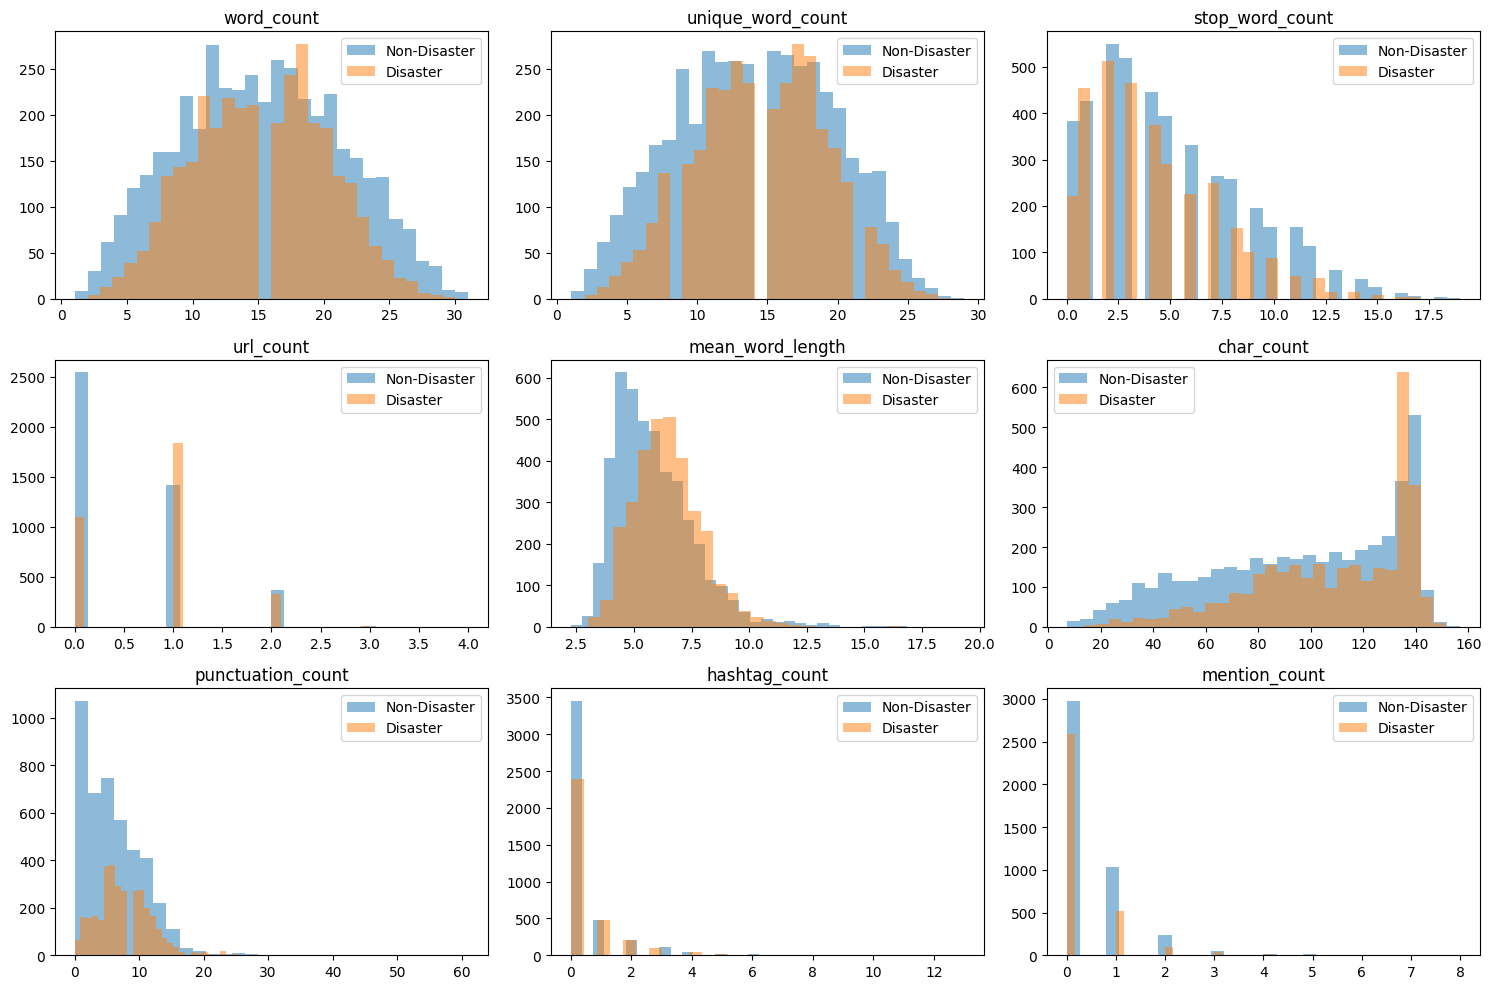

In [5]:
# Visualize each meta‐feature distribution split by target class
plt.figure(figsize=(15,10))
for i, col in enumerate(train_meta.columns, start=1):
    plt.subplot(3,3,i)
    for t, label in [(0,"Non-Disaster"), (1,"Disaster")]:
        plt.hist(df_train[df_train['target']==t][col], bins=30, alpha=0.5, label=label)
    plt.title(col); plt.legend()
plt.tight_layout(); plt.show()





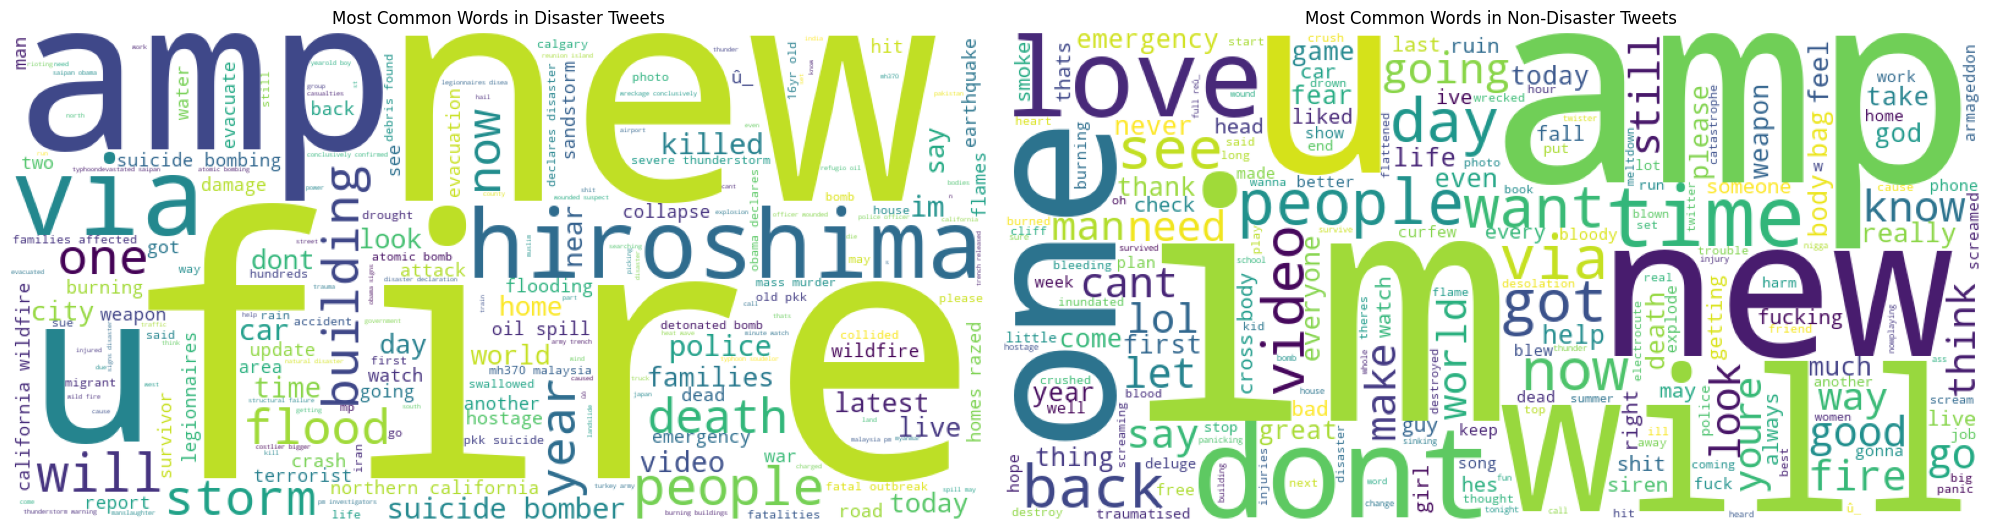

In [8]:
stop_words = set(stopwords.words('english'))

# clean_text: remove noise and drop common stopwords (articles, pronouns, prepositions, conjunctions, etc.)
def clean_text(text):
    if pd.isna(text):
        return ""
    s = str(text).lower()
    s = re.sub(r'https?://\S+|www\.\S+', '', s)
    s = re.sub(r'\S+@\S+', '', s)
    s = re.sub(r'@\w+', '', s)
    s = re.sub(r'#(\w+)', r'\1', s)
    s = re.sub(r'\b\d+\b(?<!911)', '', s)
    s = re.sub(r'\brt\b', '', s)
    s = re.sub(r'[^\w\s!?]', '', s)
    s = re.sub(r'(.)\1{2,}', r'\1', s)
    # Split, remove stopwords, and rejoin
    tokens = s.split()
    tokens = [w for w in tokens if w not in stop_words]
    return ' '.join(tokens)



# Generate word clouds for disaster vs. non-disaster tweets
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

wc_disaster = WordCloud(width=800, height=400, background_color='white')\
    .generate(' '.join(dis_words))
wc_non_disaster = WordCloud(width=800, height=400, background_color='white')\
    .generate(' '.join(non_dis_words))

ax1.imshow(wc_disaster)
ax1.axis('off')
ax1.set_title('Most Common Words in Disaster Tweets')

ax2.imshow(wc_non_disaster)
ax2.axis('off')
ax2.set_title('Most Common Words in Non-Disaster Tweets')

plt.tight_layout()
plt.show()

In [9]:

# ── Tokenization & DataLoader Prep ────────────────────────────────────────────
BATCH_SIZE = 32
VAL_SPLIT  = 0.2
MAX_LENGTH = 160
MODEL_NAME = "distilbert-base-uncased"

tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)
def tokenize_batch(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=MAX_LENGTH)

from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df_train, test_size=VAL_SPLIT, random_state=42, stratify=df_train["target"])

train_ds = Dataset.from_pandas(train_df).map(tokenize_batch, batched=True)
val_ds   = Dataset.from_pandas(val_df).map(tokenize_batch, batched=True)
test_ds  = Dataset.from_pandas(df_test).map(tokenize_batch, batched=True)

drop_cols = ["__index_level_0__", "length"]
train_ds = train_ds.remove_columns([c for c in drop_cols if c in train_ds.column_names])
val_ds   = val_ds.remove_columns(  [c for c in drop_cols if c in val_ds.column_names])
test_ds  = test_ds.remove_columns( [c for c in drop_cols if c in test_ds.column_names])

train_ds = train_ds.rename_column("target", "labels")
val_ds   = val_ds.rename_column("target", "labels")

train_ds.set_format('torch', columns=['input_ids','attention_mask','labels'])
val_ds.set_format('torch',   columns=['input_ids','attention_mask','labels'])
test_ds.set_format('torch',  columns=['input_ids','attention_mask'])

# collate_fn: batch inputs into tensors
def collate_fn(batch):
    input_ids = torch.stack([x['input_ids'] for x in batch])
    attention_mask = torch.stack([x['attention_mask'] for x in batch])
    labels = torch.tensor([x['labels'] for x in batch]) if 'labels' in batch[0] else None
    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': labels}

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)


# get_predictions: return (true_labels, predicted_probs) for any DataLoader
def get_predictions(loader):
    model.eval()
    all_labels, all_probs = [], []
    with torch.no_grad():
        for batch in loader:
            inputs = {k: v.to(device) for k,v in batch.items() if k!='labels'}
            logits = model(**inputs).logits
            probs = torch.softmax(logits, dim=-1)
            all_probs.append(probs.cpu().numpy())
            if 'labels' in batch:
                all_labels.append(batch['labels'].cpu().numpy())
    return np.concatenate(all_labels, axis=0), np.concatenate(all_probs, axis=0)


# display_confusion_matrix: plot CM and print weighted F1
def display_confusion_matrix(y_true, y_probs, name):
    preds = np.argmax(y_probs, axis=1)
    cm = confusion_matrix(y_true, preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=["Non-Disaster", "Disaster"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix — {name}")
    plt.show()
    print(f"{name} F1 score: {f1_score(y_true, preds, average='weighted'):.2f}")


Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

Map:   0%|          | 0/3263 [00:00<?, ? examples/s]

In [10]:
# ── Model Initialization ──────────────────────────────────────────────────────
model  = DistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer     = AdamW(model.parameters(), lr=1e-5)
num_steps     = 2 * len(train_loader)
lr_scheduler  = get_scheduler("linear", optimizer, num_warmup_steps=0, num_training_steps=num_steps)



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1: 100%|██████████| 191/191 [27:39<00:00,  8.69s/it]


Epoch 1 — avg loss: 0.4888


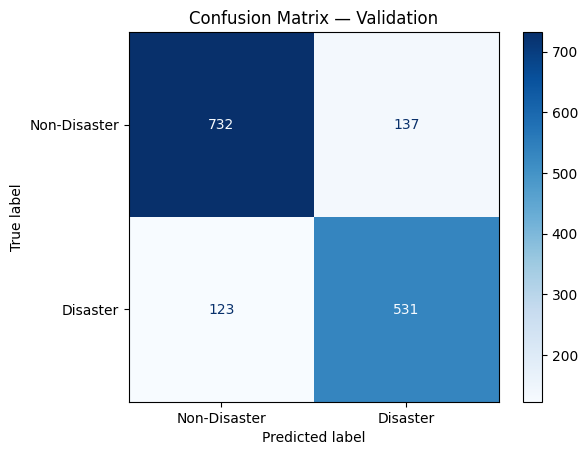

Validation F1 score: 0.83
Saved best model (F1=0.8295)


Epoch 2:  20%|██        | 39/191 [05:18<20:54,  8.25s/it]

In [ ]:
# ── Training Loop ─────────────────────────────────────────────────────────────
best_f1 = 0.0
for epoch in range(1, 3):
    model.train()
    total_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch}"):
        batch = {k: v.to(device) for k,v in batch.items()}
        optimizer.zero_grad()
        loss = model(input_ids=batch['input_ids'],
                     attention_mask=batch['attention_mask'],
                     labels=batch['labels']).loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        lr_scheduler.step()
        total_loss += loss.item()
    print(f"Epoch {epoch} — avg loss: {total_loss/len(train_loader):.4f}")

    # Validation
    y_val, p_val = get_predictions(val_loader)
    display_confusion_matrix(y_val, p_val, "Validation")
    f1_val = f1_score(y_val, np.argmax(p_val, axis=1), average='weighted')
    if f1_val > best_f1:
        best_f1 = f1_val
        torch.save(model.state_dict(), "best_model.pt")
        print(f"Saved best model (F1={best_f1:.4f})")


In [ ]:
# ── Final Evaluation ──────────────────────────────────────────────────────────
y_train, p_train = get_predictions(train_loader)
display_confusion_matrix(y_train, p_train, "Training")


Yeal:
This is where I am writing down observations and thoughts
In preprocessing, start compiling list of things to check/address in data cleanup and see how it impacts noise 


In case of nonlinear model
--Run POS to identify parts of speech, filter the data, drop unrelated words